Crypto Momentum Trading
=======================

Inspiration: Huang et.al: Cryptocurrency Volume-Weighted Time Series Momentum
Data: Polarity Digital

**Notes**

* short term reversal (buying the worst 1d momentum works), fading the best also works but is worse

**Todo**

* feature crosscorrelation
* feature predicitve ability using linear models
* non linear models
* semiparametric models

**Research**

Wang et.al, The Training Set Delusion: Use ARIMA + GARCH to forecast BTC. Use Garman-Klass or Rogers-Satchell volatility measures.

Data Preparation
----------------

In [3]:
# prepare data and compute metrics

import duckdb
from glob import glob
import re
from os.path import basename
import polars as pl
import itertools as it

con = duckdb.connect(database=':memory:')

con.sql('''
    create or replace table coins as
    with stables as (
        select unnest(['dai','bsc-usd','busd','eurc','c1usd','susds','usd1','bfusd','fdusd','pyusd','rlusd','steakusdc','syrupusdc',
           'syrupusdt','tusd','usd0','usdai','usdb','usdc.e','usdc','usdd','usde','usdf',
           'usdg','usds','usdt','usdt0','usdtb','usdy']) as symbol
    ), raw as (
        select distinct on (ts, symbol)
            timestamp as ts,
            regexp_extract(filename, 'pd-data/(.+)\\.parquet', 1) as symbol,
            price as close,
            -- volume in USD
            total_volume as volume
        from read_parquet('pd-data/*.parquet', filename=true)
        where price is not null
          and total_volume > 0
        order by ts desc

    -- all non-stablecoins
    ), base as (
        select
            r.ts,
            r.symbol,
            r.close,
            r.volume
        from raw r
        where not exists (select 1 from stables s where s.symbol = r.symbol)
          and symbol is not null
    ), ocv as (
        select
            b.ts,
            b.symbol,
            b.close,
            
            -- crypto trades 24/7 yesterday's close = today's open
            bb.close as open,
            
            -- today's log return
            ln(b.close / open) as ret,

            b.volume,
            bb.volume as pvol
        from base b
        asof join base bb
            on b.symbol = bb.symbol
            and bb.ts < b.ts
        where b.ts - bb.ts <= interval '25 hour'
        
    -- lags used for various features
    ), params as (
        select unnest([1,2,3,4,5,10,15,20,30,60,120]) as lag

    -- time series price momentum
    ), features as (
        select 
            b.ts, 
            b.symbol,
            p.lag,
            b.ret,

            -- price momentum
            sum(b.ret) over (
                partition by b.symbol, p.lag
                order by b.ts 
                rows between p.lag preceding and 1 preceding
            ) as mom,

            -- log return AR(1)
            corr(b.ret, bb.ret) over (
                partition by b.symbol, p.lag
                order by b.ts 
                rows between p.lag preceding and 1 preceding
            ) as autocorr,

            -- log return volatility
            stddev(b.ret) over (
                partition by b.symbol, p.lag
                order by b.ts 
                rows between p.lag preceding and 1 preceding
            ) as sigma,

            -- price level
            ln(b.open / mean(b.close) over (
                partition by b.symbol, p.lag
                order by b.ts 
                rows between p.lag preceding and 1 preceding
            )) as level,

            -- volume level
            ln(b.volume / mean(b.volume) over (
                partition by b.symbol, p.lag
                order by b.ts 
                rows between p.lag preceding and 1 preceding
            )) as vol

        from ocv b
        cross join params p
        asof join ocv bb
            on b.symbol = bb.symbol
            and bb.ts < b.ts
        where b.ts - bb.ts <= interval '25 hour'
         
    )
    select *
    from features;

-- cross-sectionally normalized feature
create or replace table cs_features as
with narrow as (
    unpivot coins
    on mom, autocorr, sigma, level, vol, ret
    into
        name feature value value
), z as (
    select
        ts, symbol, lag, feature,
        (value - mean(value) over csw) / stddev(value) over csw as zscore
    from narrow
    where value is not null and isfinite(value)
    window csw as (partition by ts, lag, feature)
)
pivot z
on feature
using any_value(zscore);

-- timeseries normalized feature
create or replace table ts_features as
with narrow as (
    unpivot coins
    on mom, autocorr, sigma, level, vol, ret
    into
        name feature value value
), z as (
    select
        ts, symbol, lag, feature,
        (value - mean(value) over tsw) / stddev(value) over tsw as zscore
    from narrow
    where value is not null and isfinite(value)
    window tsw as (partition by symbol, lag, feature)
)
pivot z
on feature
using any_value(zscore);
''')

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Correlations with various features, lags and normalization
----------------------------------------------------------

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

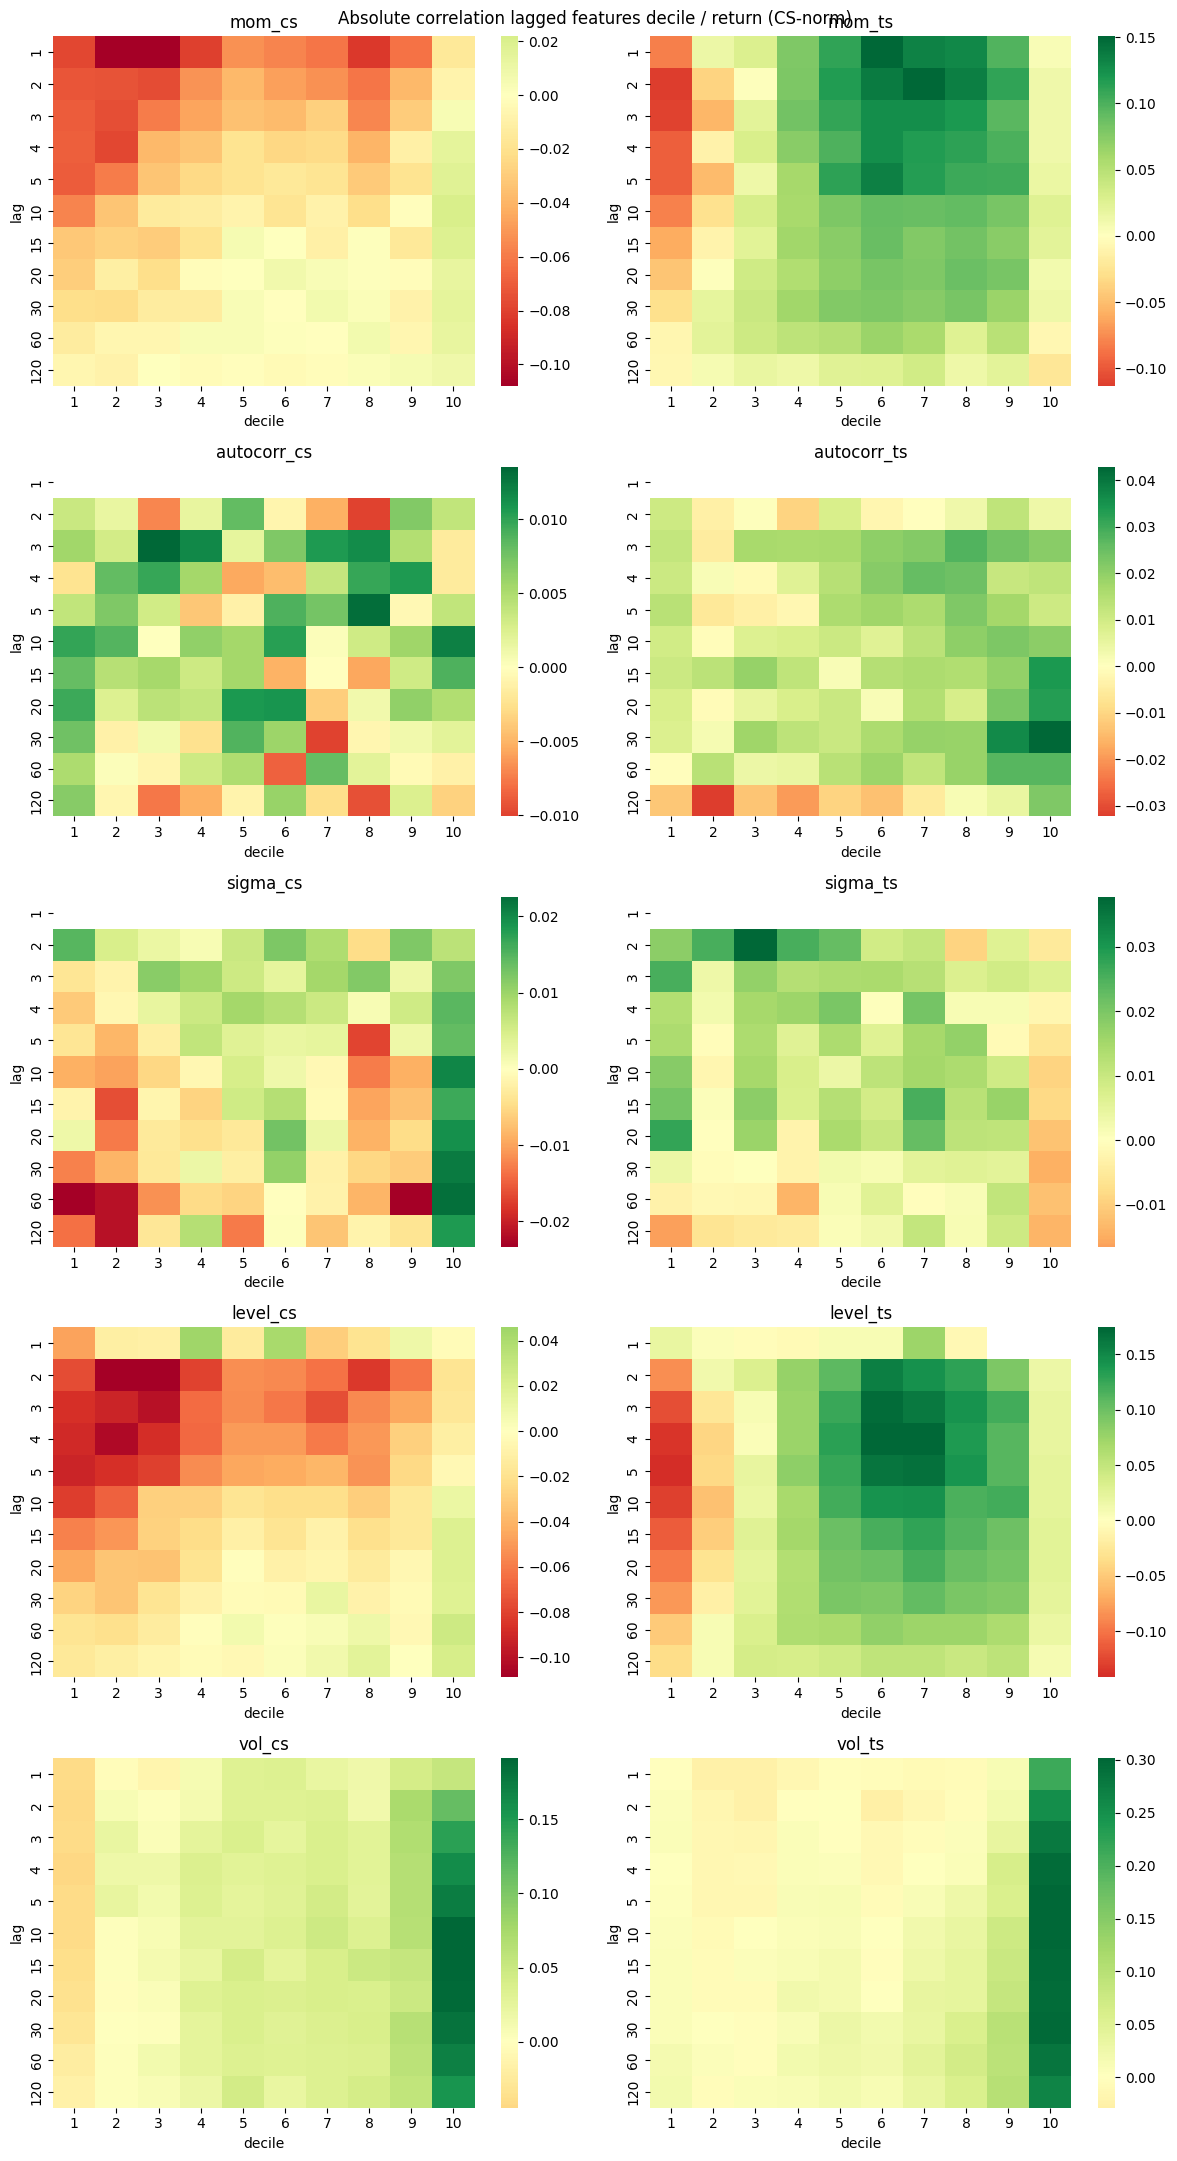

In [125]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

df = con.sql('''
    with cs as (
        unpivot cs_features
        on columns('(mom|autocorr|sigma|level|vol)') as '\\0_cs'
        into
            name feature value value
    ), ts as (
        unpivot ts_features
        on columns('(mom|autocorr|sigma|level|vol)') as '\\0_ts'
        into
            name feature value value
    ), deciles as (
        select
            lag, ret, feature, value,
            ntile(10) over (partition by ts, lag, feature order by value asc) as decile
        from (
            select * from cs
            union select * from ts
        )
    ), corr as (
        select lag, feature, decile, corr(ret, value) as corr
        from deciles
        where value is not null and isfinite(value)
        group by lag, decile, feature
    )
    pivot corr
    on feature
    using any_value(corr)
''').df()

feats = list(map(lambda p: f'{p[0]}_{p[1]}', it.product(['mom','autocorr','sigma','level','vol'], ['cs','ts'])))
fig, axes = plt.subplots(5, 2, figsize=(12, 22))
axes = axes.flatten().tolist()

for ax, feat in zip(axes, feats):
    sns.heatmap(
        df.pivot(index='lag', columns='decile', values=feat),
        cmap='RdYlGn',center=0,ax=ax)
    ax.set_title(feat)

while len(axes) > len(feats):
    fig.delaxes(axes.pop())
    
fig.suptitle('Absolute correlation lagged features decile / return (CS-norm)')
fig.tight_layout()
plt.show()

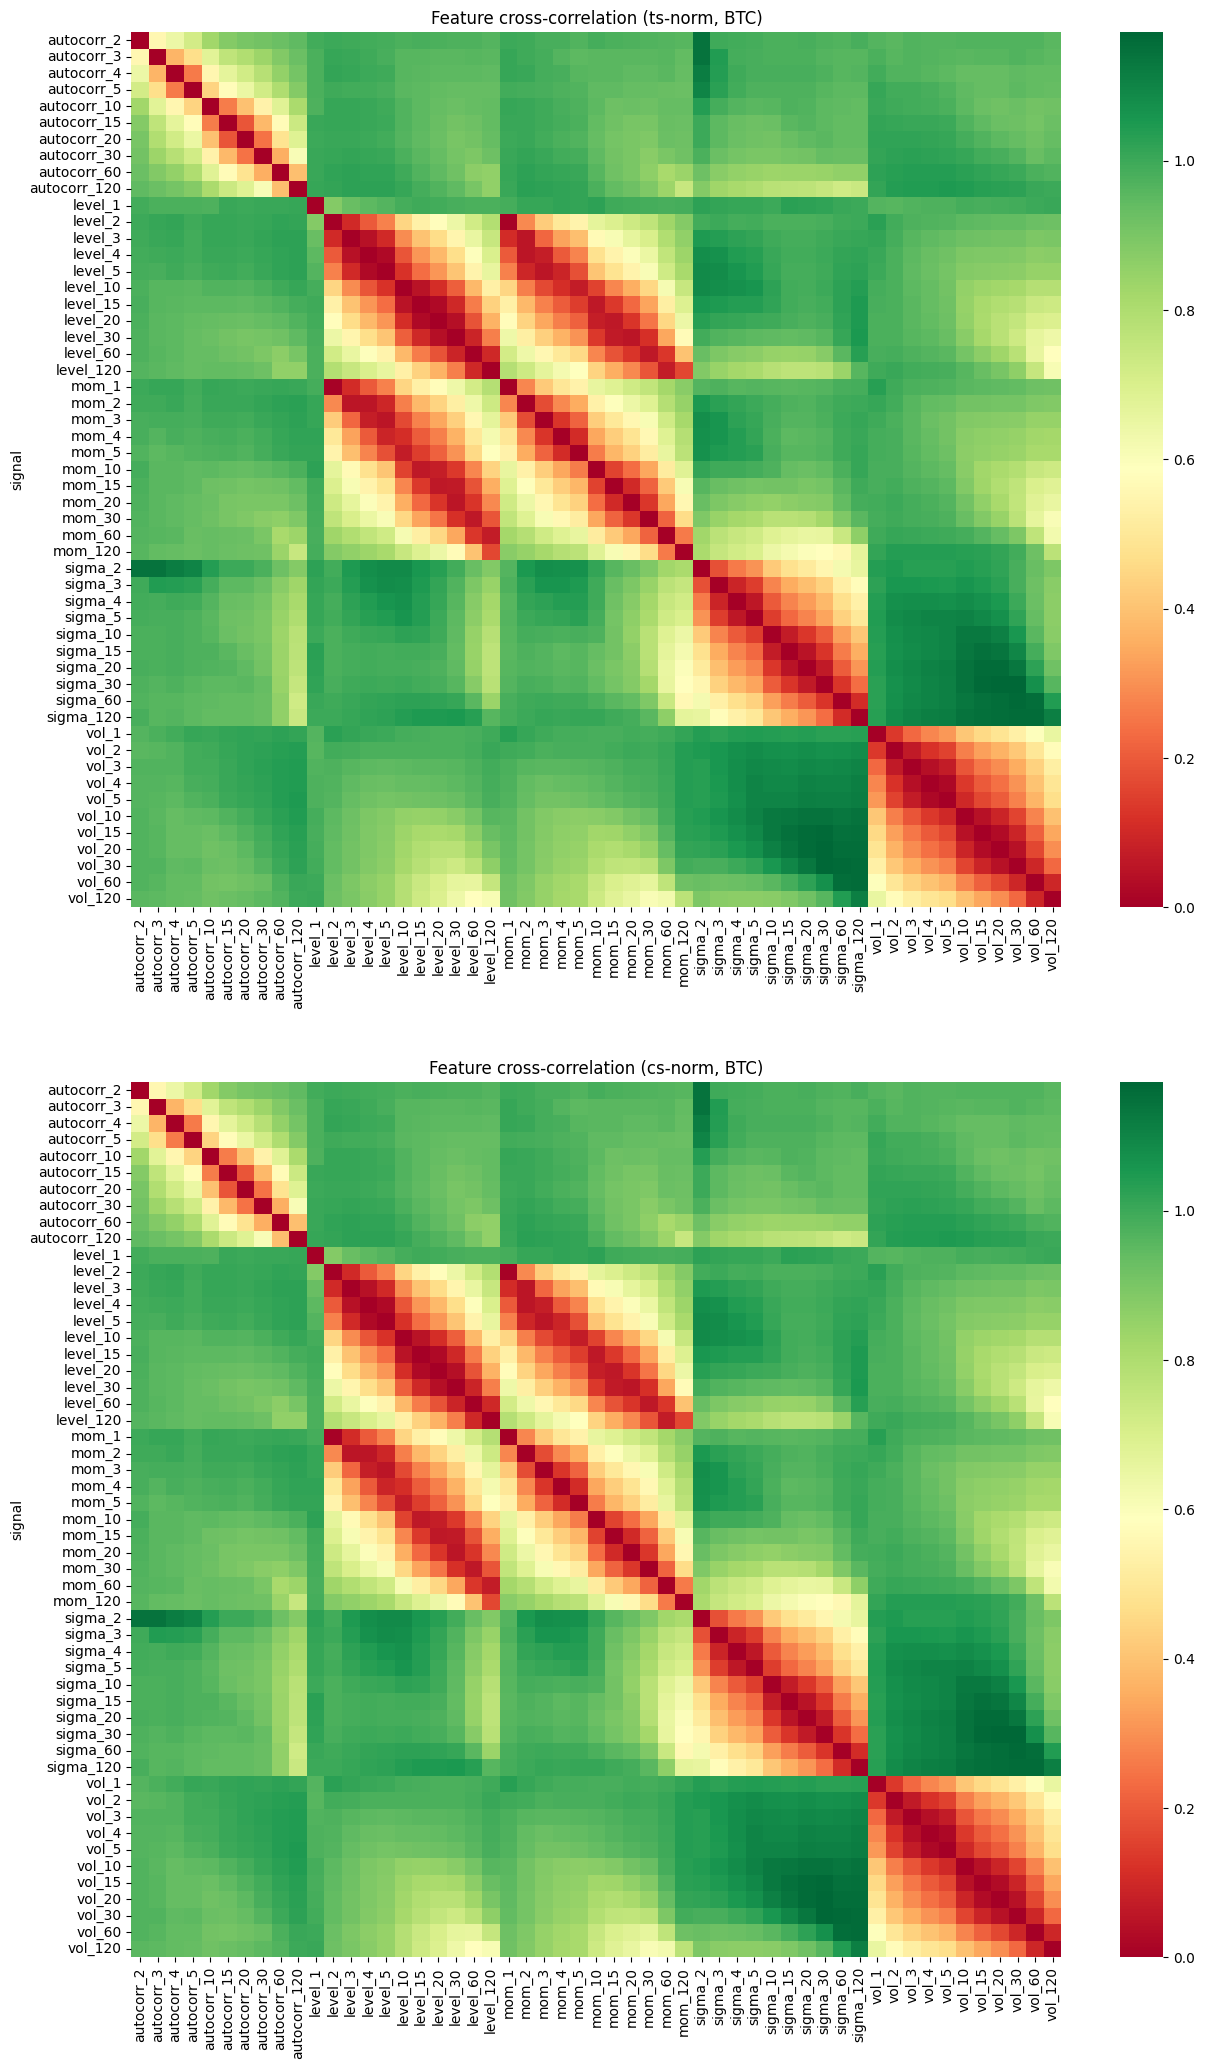

In [81]:
from natsort import natsorted

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 1, figsize=(15, 25))

for [ax, norm] in zip(axs,['ts','cs']):
    df = con.sql(f'''
        with narrow as (
            unpivot {norm}_features
                on mom, autocorr, sigma, level, vol, ret
                into
                    name feature value value
        ), features as (
            select
                ts, value, feature || '_' || lag as feature
            from narrow
            where value is not null
              and symbol = 'btc'
        )
        pivot features
            on feature
            using first(value)
            group by ts
            order by ts
    ''').pl()
    
    df = df.drop_nans().drop_nulls().select(natsorted(df.columns)).corr().to_pandas()
    xc['signal'] = xc.columns.to_list()
    xc.set_index('signal', inplace=True)
    
    sns.heatmap(1-xc,cmap='RdYlGn',ax=ax)
    ax.set_title(f'Feature cross-correlation ({norm}-norm, BTC)')
    
plt.show()

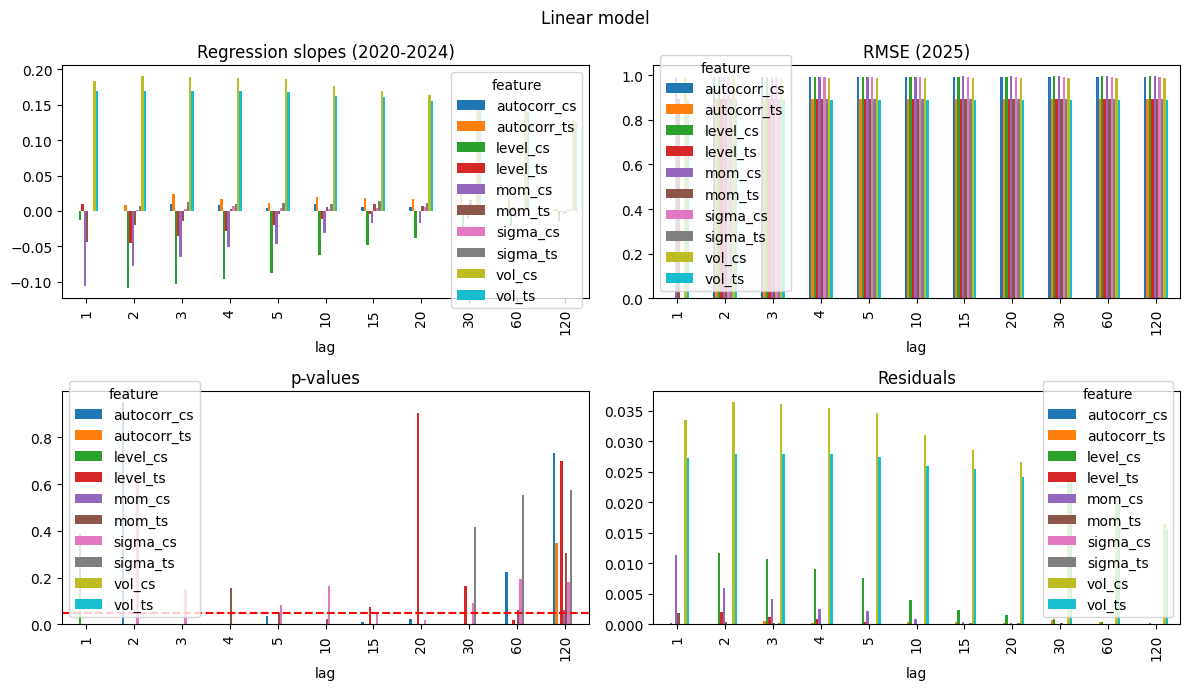

In [5]:
from scipy import stats
df['p'] = df.apply(lambda r: stats.t.sf(abs(r.t), r.n - 2) * 2, axis=1)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,7))

df.pivot(index='lag',columns='feature',values='b1').plot(
    kind='bar', ax=axes[0,0],title='Regression slopes (2020-2024)')
df.pivot(index='lag',columns='feature',values='rmse').plot(
    kind='bar', ax=axes[0,1],title='RMSE (2025)')
df.pivot(index='lag',columns='feature',values='p').plot(
    kind='bar', ax=axes[1,0],title='p-values')
axes[1,0].axhline(y=0.05, color='red', linestyle='dashed')
df.pivot(index='lag',columns='feature',values='rsq').plot(
    kind='bar',title='Residuals', ax=axes[1,1])

plt.suptitle('Linear model')
plt.tight_layout()
plt.show()

In [122]:
import polars as pl
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import f_regression

df = con.sql('''
    with narrow as (
        unpivot ts_features
            on mom, autocorr, sigma, level, vol, ret
            into
                name feature value value
    ), features as (
        select
            ts, value, feature || '_' || lag as feature
        from narrow
        where value is not null
            and symbol = 'sol'
    )
    pivot features
        on feature
        using first(value)
        group by ts
        order by ts
''').pl()

df = df.drop_nans().drop_nulls()

X_train, X_test, y_train, y_test = train_test_split(
    df[list(filter(lambda n: re.search(r'(mom|autocorr|sigma|vol)', n), df.columns))],
    df['ret_1'],
    test_size=0.2,
    random_state=42)

del df

_, p_values = f_regression(
    X_train.to_pandas(), 
    y_train.to_pandas().squeeze() 
)
lin = pd.DataFrame({'rmse': np.nan, 'r2': np.nan, 'p': p_values},
                   index=X_train.columns)

for feat in X_train.columns:
    model = LinearRegression().fit(X_train.select(feat), y_train)
    
    yy = model.predict(X_test.select(feat))
    
    r2 = r2_score(y_test, yy)
    rmse = np.sqrt(mean_squared_error(y_test, yy))
    lin.loc[feat, ['rmse', 'r2']] = [rmse, r2]
    
    

lin = lin[lin.p < 0.05].sort_values('p')

print(lin)

                 rmse        r2             p
vol_60       1.053022 -0.007732  3.763066e-07
vol_30       1.052014 -0.005804  5.652033e-07
vol_120      1.051342 -0.004519  9.155417e-07
vol_20       1.050827 -0.003535  5.118249e-06
vol_15       1.050811 -0.003504  1.176481e-05
vol_10       1.047776  0.002285  1.658984e-05
vol_5        1.045482  0.006649  2.865984e-05
vol_4        1.044186  0.009109  4.682262e-05
vol_3        1.043563  0.010291  9.870489e-05
vol_1        1.042529  0.012251  2.041901e-04
vol_2        1.042150  0.012970  2.114832e-04
mom_30       1.054254 -0.010091  4.081037e-04
mom_20       1.055117 -0.011745  7.889514e-04
mom_15       1.057820 -0.016936  1.138654e-03
mom_10       1.056715 -0.014813  5.559490e-03
sigma_120    1.050284 -0.002499  1.000712e-02
sigma_2      1.054349 -0.010274  1.134471e-02
sigma_20     1.052768 -0.007246  2.040398e-02
sigma_15     1.050916 -0.003706  2.389966e-02
mom_60       1.048942  0.000062  4.421073e-02
autocorr_3   1.048696  0.000531  4

<Axes: xlabel='feature'>

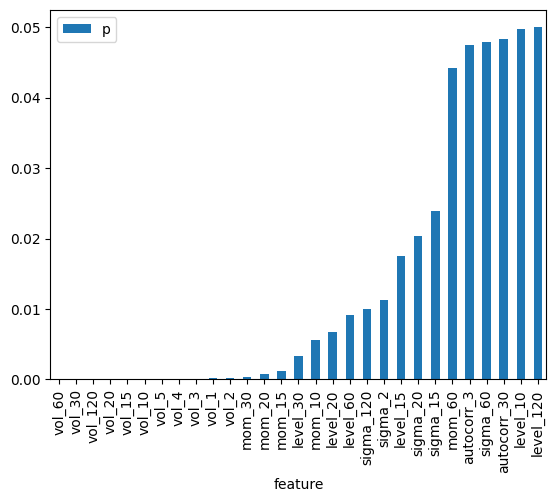

In [5]:
# vol weight allocation
# add mcap
# encode crossing as triangle wave 0.01 0.1 1 (bullish cross) 0.1 0.01 and negative on bearish
# try linear models
# different up down patterns (up up down) for example 
# sma/ema slope
# above ma and rising, vol above 20 sma and rising

Encoding Type,Feature Name,Formula / Logic,Best For
Binary,Bullish Zone,1 if Fast>Slow else 0,"Decision Trees, Logic rules"
Continuous,Normalized Spread,(Fast−Slow)/Slow,"Neural Networks, Linear Regression"
Temporal,Trend Age,Count of bars since cross,Mean Reversion models
Velocity,Spread Momentum,Δ(Fast−Slow),Momentum strategies
 
duckdb.sql('''
create or replace table returns as
select
    year(ts) as year,
    symbol,
    lag,
    sum(ret) as ret
from momentum
where mom > 0
group by year, symbol, lag
''')

duckdb.sql('''
create or replace table cross_alpha as
select
    r.year,
    r.lag,
    avg(r.ret - b.ret) as ret
from returns r
join benchmark b
  on b.year = r.year
group by r.year, r.lag
''')

CatalogException: Catalog Error: Table with name momentum does not exist!
Did you mean "pg_enum"?

LINE 8: from momentum
             ^